In [2]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium as fol
from folium.plugins import MarkerCluster as folmc
from folium.plugins import FastMarkerCluster as folfmc
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices as dmat

%matplotlib inline

## NSS Data Science Project 2 - Silver Sharks Geospatial API

### 1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [3]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000"

params = {
     'offense_description': 'BURGLARY- AGGRAVATED'
    ,'$where': "incident_reported between '2021-01-01T00:00:01.000' and '2021-06-30T23:59:59.000'"
}

In [4]:
response = requests.get(endpoint, params)

In [5]:
res = response.json()

In [6]:
res_trimmed = pd.DataFrame(res, columns=['incident_reported', 
                                         'offense_description', 
                                         'latitude', 
                                         'longitude', 
                                         'zip_code'])

res_trimmed['incident_reported'] = res_trimmed['incident_reported'].str\
                                                                   .split("T", expand=True)[0]

burglary_reports = res_trimmed[res_trimmed['offense_description'].str\
                                                                 .contains('BURGLARY- AGGRAVATED')]

burglary_reports.head()

,incident_reported,offense_description,latitude,longitude,zip_code
0,2021-05-05,BURGLARY- AGGRAVATED,36.15,-86.77,NaN
1,2021-05-04,BURGLARY- AGGRAVATED,36.2,-86.63,NaN
2,2021-05-02,BURGLARY- AGGRAVATED,36.14,-86.78,NaN
3,2021-05-02,BURGLARY- AGGRAVATED,36.14,-86.78,NaN
4,2021-05-05,BURGLARY- AGGRAVATED,36.15,-86.77,NaN


In [7]:
burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']]\
                                                                                         .apply(pd.to_numeric);

burglary_reports.shape

(1051, 5)

### 2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

By my calculations, Census Tract 163 had by far the highest number of burglaries with 53 (once we have eliminated duplicate incident numbers).

In [8]:
census_tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [9]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [10]:
burglary_reports['geometry'] = burglary_reports\
                                               .apply(lambda x: Point((x.longitude,
                                                                       x.latitude)),
                                                      axis=1)

burglary_reports.head()

,incident_reported,offense_description,latitude,longitude,zip_code,geometry
0,2021-05-05,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,POINT (-86.77 36.15)
1,2021-05-04,BURGLARY- AGGRAVATED,36.20,-86.63,NaN,POINT (-86.63 36.2)
2,2021-05-02,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,POINT (-86.78 36.14)
3,2021-05-02,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,POINT (-86.78 36.14)
4,2021-05-05,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,POINT (-86.77 36.15)


In [11]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,  
                                crs=census_tract.crs,
                                geometry = burglary_reports['geometry'])

In [12]:
census_tract = census_tract[['COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)
census_tract = census_tract[census_tract['COUNTYFP'] == 37]
census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [15]:
burglary_by_tract = gpd.sjoin(burglary_geo,  # MICHAEL SAYS CHANGE THE ORDER OF THESE--
                              census_tract,  # BUT YOU GET AN ERROR
                              op = 'within')

In [18]:
burglary_by_tract.drop_duplicates(subset='geometry', 
                                  inplace=True)

burglary_by_tract = burglary_by_tract.rename(columns={'TRACTCE':'tract'})

burglary_by_tract.head()

,incident_reported,offense_description,latitude,longitude,zip_code,geometry,COUNTYFP,tract,NAME
0,2021-05-05,BURGLARY- AGGRAVATED,36.150,-86.77,NaN,POINT (-86.77000 36.15000),37,016000,160
63,2021-04-02,BURGLARY- AGGRAVATED,36.140,-86.76,NaN,POINT (-86.76000 36.14000),37,016000,160
1,2021-05-04,BURGLARY- AGGRAVATED,36.200,-86.63,NaN,POINT (-86.63000 36.20000),37,015402,154.02
58,2021-02-27,BURGLARY- AGGRAVATED,36.190,-86.64,NaN,POINT (-86.64000 36.19000),37,015402,154.02
652,2021-05-17,BURGLARY- AGGRAVATED,36.188,-86.63,37076,POINT (-86.63000 36.18800),37,015402,154.02


In [19]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)

polygon_nash = pd.merge(census_tract, 
                        census_tract_names, 
                        on = 'NAME')

polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
3,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
4,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
8,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
12,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
...,...,...,...,...
422,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
424,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
425,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
429,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


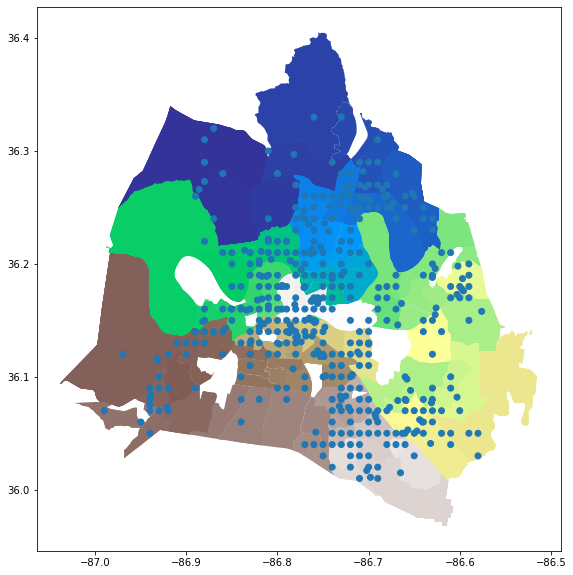

In [20]:
ax = polygon_nash.plot(column='TRACTCE', 
                       figsize = (10, 10), 
                       cmap='terrain')

burglary_by_tract.plot(ax = ax, 
                       column = 'offense_description')

plt.show();

### 3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [22]:
endpoint_pop = "https://api.census.gov/data/2019/acs/acs5"
params_pop = {
       'get' : 'NAME,B01001_001E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : # API KEY
}

endpoint_income = "https://api.census.gov/data/2019/acs/acs5/subject"
params_income = {
       'get' : 'NAME,S1901_C01_012E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : # API KEY
}

In [23]:
response_pop = requests.get(endpoint_pop, params=params_pop)

response_income = requests.get(endpoint_income, params=params_income)

In [24]:
res_pop = response_pop.json()
population = pd.DataFrame(res_pop)
#changes column names
population.columns = population.iloc[0]
population = population[1:]
display(population.head())

res_income = response_income.json()
med_income = pd.DataFrame(res_income) 
#changes colum names 
med_income.columns = med_income.iloc[0]
med_income = med_income[1:]
display(med_income.head())

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301


,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",75579,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",45129,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",134786,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",107813,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",87591,47,037,018301


In [26]:
pop_and_income = pd.merge(population, 
                          med_income, 
                          how='inner')

pop_and_income = pop_and_income.rename(columns={'B01001_001E': 'population',
                                               'S1901_C01_012E':'median_income'})
pop_and_income.head()

,NAME,population,state,county,tract,median_income
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75579
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,45129
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,134786
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,107813
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,87591


In [27]:
burglaries_and_var = pd.merge(burglary_by_tract, 
                              pop_and_income, 
                              on='tract')

burglaries_and_var = burglaries_and_var\
                                       .drop(columns=['latitude', 
                                                      'longitude', 
                                                      'zip_code',
                                                      'NAME_x',
                                                      'NAME_y'])
burglaries_and_var.head()

,incident_reported,offense_description,geometry,COUNTYFP,tract,population,state,county,median_income
0,2021-05-05,BURGLARY- AGGRAVATED,POINT (-86.77000 36.15000),37,016000,945,47,037,37083
1,2021-04-02,BURGLARY- AGGRAVATED,POINT (-86.76000 36.14000),37,016000,945,47,037,37083
2,2021-05-04,BURGLARY- AGGRAVATED,POINT (-86.63000 36.20000),37,015402,4717,47,037,69740
3,2021-02-27,BURGLARY- AGGRAVATED,POINT (-86.64000 36.19000),37,015402,4717,47,037,69740
4,2021-05-17,BURGLARY- AGGRAVATED,POINT (-86.63000 36.18800),37,015402,4717,47,037,69740


In [28]:
type(burglaries_and_var)

geopandas.geodataframe.GeoDataFrame

In [29]:
#tract_counts = pd.DataFrame(burglaries_and_var['tract'].value_counts())
tract_counts = pd.DataFrame(burglaries_and_var['tract'].value_counts())
tract_counts = tract_counts.rename(columns={'tract':'burglary_count'})

pop_income = pd.DataFrame(burglaries_and_var[['tract', 
                                              'population', 
                                              'median_income']])
pop_income = pop_income.set_index('tract')

tract_pop_income = pd.merge(pop_income, tract_counts, 
                            left_index=True, right_index=True)

tract_pop_income = tract_pop_income.drop_duplicates(keep='first')

tract_pop_income.reset_index(level=0, inplace=True)
tract_pop_income = tract_pop_income.rename(columns={'index': 'tract'})

tract_pop_income[['population', 'median_income']] = tract_pop_income[['population', 'median_income']]\
                                                                                                     .apply(pd.to_numeric)
tract_pop_income = tract_pop_income[tract_pop_income['population'] >= 0]
tract_pop_income = tract_pop_income[tract_pop_income['median_income'] >= 0]

tract_pop_income.head()

,tract,population,median_income,burglary_count
0,010104,2955,64844,4
1,010105,4435,64688,3
2,010106,3397,63864,3
3,010201,4157,62829,4
4,010202,3962,78750,1


In [30]:
tract_pop_income['burg_per_1000'] = ((tract_pop_income['burglary_count'] / tract_pop_income['population']) * 1000)
tract_pop_income['log_population'] = np.log(tract_pop_income['population'])
tract_pop_income.head()

,tract,population,median_income,burglary_count,burg_per_1000,log_population
0,010104,2955,64844,4,1.353638,7.991254
1,010105,4435,64688,3,0.676437,8.397283
2,010106,3397,63864,3,0.883132,8.130648
3,010201,4157,62829,4,0.962232,8.332549
4,010202,3962,78750,1,0.252398,8.284504


### 4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [31]:
pop_inc_geo = pd.merge(burglaries_and_var, 
                       tract_pop_income,
                       on = 'tract')

In [32]:
pop_inc_geo.head(5)

,incident_reported,offense_description,geometry,COUNTYFP,tract,population_x,state,county,median_income_x,population_y,median_income_y,burglary_count,burg_per_1000,log_population
0,2021-05-05,BURGLARY- AGGRAVATED,POINT (-86.77000 36.15000),37,016000,945,47,037,37083,945,37083,2,2.116402,6.851185
1,2021-04-02,BURGLARY- AGGRAVATED,POINT (-86.76000 36.14000),37,016000,945,47,037,37083,945,37083,2,2.116402,6.851185
2,2021-05-04,BURGLARY- AGGRAVATED,POINT (-86.63000 36.20000),37,015402,4717,47,037,69740,4717,69740,5,1.059996,8.458928
3,2021-02-27,BURGLARY- AGGRAVATED,POINT (-86.64000 36.19000),37,015402,4717,47,037,69740,4717,69740,5,1.059996,8.458928
4,2021-05-17,BURGLARY- AGGRAVATED,POINT (-86.63000 36.18800),37,015402,4717,47,037,69740,4717,69740,5,1.059996,8.458928


In [33]:
pop_inc_geo = pop_inc_geo.drop(columns='incident_reported')

In [34]:
pop_inc_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 438 entries, 0 to 437
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   offense_description  438 non-null    object  
 1   geometry             438 non-null    geometry
 2   COUNTYFP             438 non-null    int64   
 3   tract                438 non-null    object  
 4   population_x         438 non-null    object  
 5   state                438 non-null    object  
 6   county               438 non-null    object  
 7   median_income_x      438 non-null    object  
 8   population_y         438 non-null    int64   
 9   median_income_y      438 non-null    int64   
 10  burglary_count       438 non-null    int64   
 11  burg_per_1000        438 non-null    float64 
 12  log_population       438 non-null    float64 
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 47.9+ KB


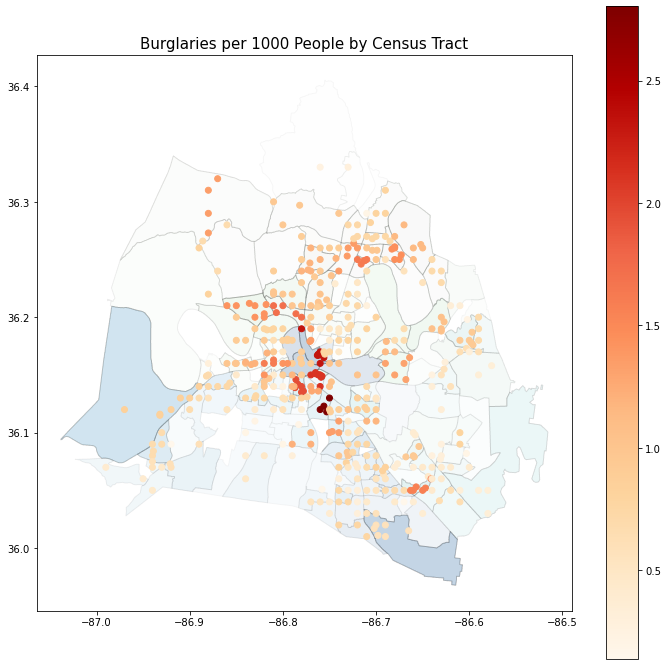

In [35]:
ax = polygon_nash.plot(column='TRACTCE', 
                       figsize = (12, 12), 
                       edgecolor='black',
                       alpha=0.03,
                       cmap='GnBu')
pop_inc_geo.plot(column = 'burg_per_1000',
                 cmap='OrRd',
                 legend=True,
                 ax=ax)
plt.title('Burglaries per 1000 People by Census Tract',
          fontsize=15)
plt.show();